<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/future/Week9-draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%config InlineBackend.figure_formats = ["retina"]

In [3]:
!pip install -q osmnx descartes scikit-learn

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.lines as mlines

from tqdm import tqdm
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from joblib import Parallel, delayed

ox.__version__

'2.0.1'

# Cities and Transit
This week's notebook will be focused on cities and transit. We'll focus on a variety of transit-related datasets from the [NYC](https://data.cityofnewyork.us/browse?sortBy=relevance&pageSize=20&category=Transportation&page=1) and [NY State](https://data.ny.gov/browse?category=Transportation&utf8=%E2%9C%93&sortBy=relevance&page=1&pageSize=20) Open Data Portals. Explore these sites on your own as inspiration for your final projects!

A lot of transportation data can be visualized using networks and flow maps, similar to previous weeks. For example, we can examine [Yellow Taxi Trips](https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data) between pairs of NYC neighborhoods or look at [MTA daily ridership](https://data.ny.gov/Transportation/MTA-Daily-Ridership-Data-2020-2025/vxuj-8kew/about_data) between stations.

However, *measuring distance* is another kind of question that's useful to study in the context of transportation --- relevant to questions like:
* how many subway stations are located within 10 minutes of a park?
* how does voter access to a poll site vary by neighborhood?

While conventional straight-line distance measurements may provide approximate answers to these questions, a better and more realistic approach involves analyzing cities via the *street network*.

In this notebook, we'll discuss open-source approaches to calculating *network distances*, which are distances measured along a network (e.g., a street network). We'll also learn how to make an [isochrone map](https://en.wikipedia.org/wiki/Isochrone_map), which is a type of map that depicts all the area accessible within a given travel time.

In [5]:
subway_stations = gpd.read_file('https://data.ny.gov/resource/39hk-dx4f.geojson?$limit=100000')
subway_stations.head()

station_id north_direction_label     line daytime_routes complex_id  \
0          1             Last Stop  Astoria            N W          1   
1          2               Astoria  Astoria            N W          2   
2          3               Astoria  Astoria            N W          3   
3          4               Astoria  Astoria            N W          4   
4          5               Astoria  Astoria            N W          5   

  division ada_southbound gtfs_stop_id structure ada_notes  \
0      BMT              0          R01  Elevated      None   
1      BMT              1          R03  Elevated      None   
2      BMT              0          R04  Elevated      None   
3      BMT              0          R05  Elevated      None   
4      BMT              0          R06  Elevated      None   

              stop_name gtfs_longitude ada_northbound ada  \
0  Astoria-Ditmars Blvd     -73.912034              0   0   
1          Astoria Blvd     -73.917843              1   1   
2                 30 Av     -73.921479              0   0   
3              Broadway     -73.925508              0   0   
4                 36 Av     -73.929575              0   0   

  south_direction_label    cbd borough gtfs_latitude  \
0             Manhattan  False       Q     40.775036   
1             Manhattan  False       Q     40.770258   
2             Manhattan  False       Q     40.766779   
3             Manhattan  False       Q      40.76182   
4             Manhattan  False       Q     40.756804   

                     geometry  
0  POINT (-73.91203 40.77504)  
1  POINT (-73.91784 40.77026)  
2  POINT (-73.92148 40.76678)  
3  POINT (-73.92551 40.76182)  
4   POINT (-73.92958 40.7568)

In [6]:
parks = gpd.read_file('https://nycopendata.socrata.com/resource/enfh-gkve.geojson?$limit=100000')
parks.head()

jurisdiction mapped zipcode  acres  \
0          DPR   True   10034  0.545   
1          DPR  False   10457  2.213   
2          DPR  False   10460  0.114   
3          DPR  False   11373  6.219   
4          DPR   True   10021  3.312   

                                       location nys_assembly councildistrict  \
0                       Broadway and W. 204 St.           72              10   
1        E 182 St bet. Belmont Av and Croton Av           78              15   
2  Hornaday Pl bet. Crotona Pkwy and Mohegan Av           87              15   
3    Grand Ave., 57 Ave. bet. 74 St. and 80 St.           30              30   
4                 FDR Dr., E 76 St. To E 78 St.           76               5   

          typecategory us_congress                  eapply  ...   gisobjid  \
0  Historic House Park          13    Dyckman House Museum  ...  100003823   
1           Playground          15      Belmont Playground  ...  100004948   
2               Garden          15  Volky Garden & Flowers  ...  100005124   
3       Community Park           6           Elmhurst Park  ...  100000211   
4       Community Park          12           John Jay Park  ...  100004745   

                 signname              address permitparent class nys_senate  \
0    Dyckman House Museum        4901 BROADWAY         M-12  PARK         31   
1      Belmont Playground  670 EAST 182 STREET         X-06  PARK         32   
2  Volky Garden & Flowers   851 HORNADAY PLACE         X-06  PARK         32   
3           Elmhurst Park      78-01 57 AVENUE         Q-04  PARK         12   
4           John Jay Park      76-01 FDR DRIVE         M-08  PARK         28   

  permitdistrict borough  waterfront  \
0           M-12       M         0.0   
1           X-06       X         0.0   
2           X-06       X         0.0   
3           Q-04       Q         0.0   
4           M-08       M         0.0   

                                            geometry  
0  MULTIPOLYGON (((-73.92305 40.86718, -73.92248 ...  
1  MULTIPOLYGON (((-73.88697 40.85004, -73.88724 ...  
2  MULTIPOLYGON (((-73.88234 40.84707, -73.88248 ...  
3  MULTIPOLYGON (((-73.88437 40.72891, -73.8841 4...  
4  MULTIPOLYGON (((-73.94904 40.76901, -73.94851 ...  

[5 rows x 34 columns]

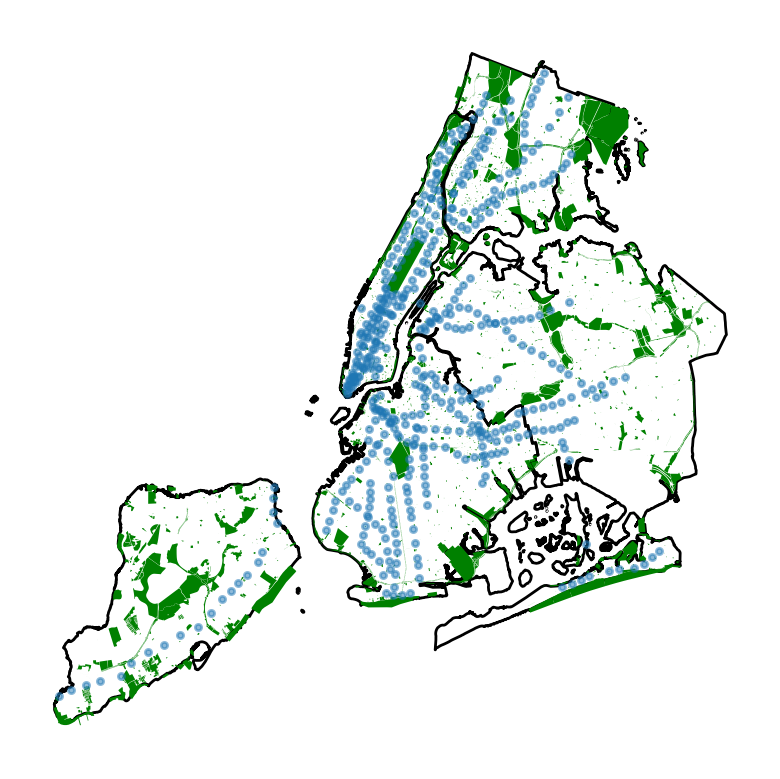

In [7]:
boros = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')
ax = boros.plot(facecolor='none')
parks.plot(ax=ax, facecolor='green')
subway_stations.plot(ax=ax, alpha=0.5, markersize=5)
ax.set_axis_off();

Let's look at how many subway stations are located within 10 minutes of a park *on average*. 10 minutes walking is roughly a half-mile, so we can equivalently examine the average number of parks within 0.5 miles from a park.

A simple way to do this is to create a [buffer](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) in Geopandas, and apply this to the park data. A buffer will return a new geometry containing the original geometry and all the area within a given distance from the original geometry.

First, to specify the correct distance we'll need to make sure that we're in the right projected coordinate system. We'll use [EPSG: 2263](https://spatialreference.org/ref/epsg/2263/), which is a standard projected coordinate system for the NYC area and uses feet as the unit of measurement.

In [8]:
print(parks.crs)
parks_proj = parks.to_crs(2263)
# convert to projected coordinate system!
print(parks_proj.crs)

EPSG:4326
EPSG:2263


In [9]:
# create a buffer of 2640 feet
parks_buffer = parks_proj.copy()
parks_buffer['geometry'] = parks_proj.buffer(2640)

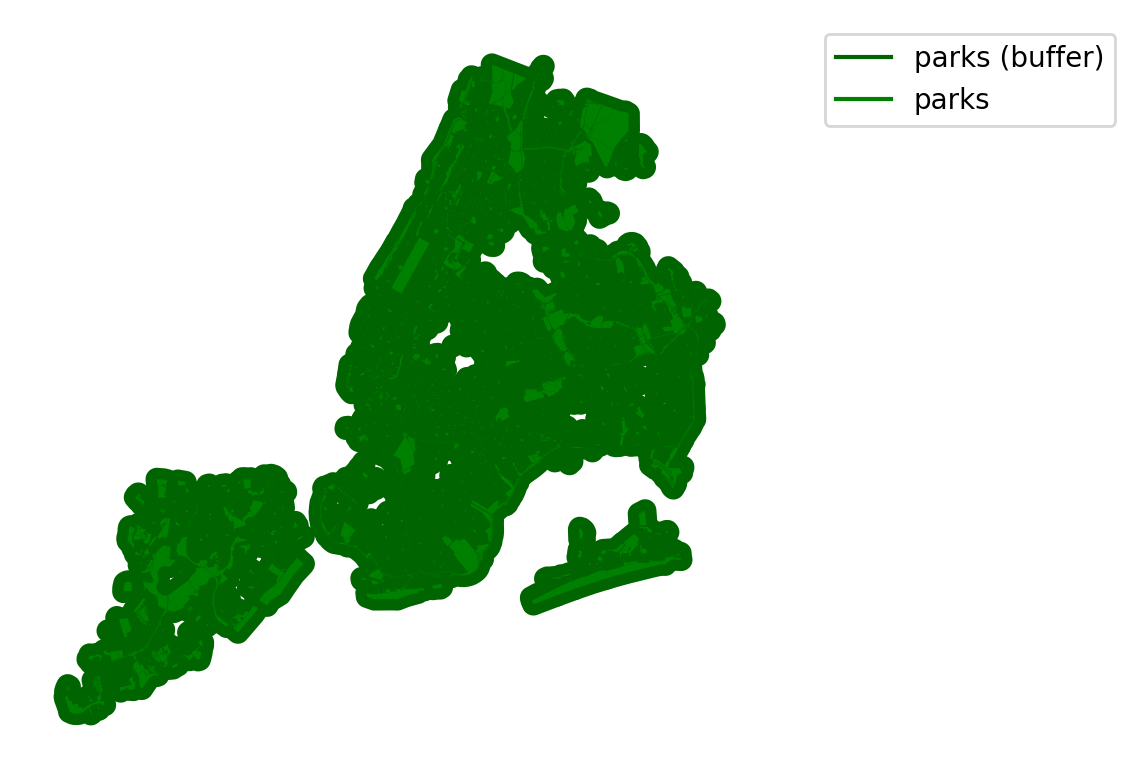

In [10]:
ax = parks_buffer.plot(color='darkgreen')
parks_proj_plot = parks_proj.plot(ax=ax, color='green')

# defining legend style and data
parks_buffer_handle = mlines.Line2D([], [], color='darkgreen', label='parks (buffer)')
parks_handle = mlines.Line2D([], [], color='green', label='parks')

ax.legend(handles=[parks_buffer_handle, parks_handle], loc='upper right', bbox_to_anchor=(1.5, 1))
ax.set_axis_off();

Now, we'll use a [spatial join](https://geopandas.org/en/stable/gallery/spatial_joins.html) to identify the points that intersect the parks buffer. A spatial join works similar to a regular join, but it uses the concept of a spatial intersection or overalp to join the geodataframes rather than an index column.

In [11]:
# check the crs again!
print(subway_stations.crs)
subway_stations = subway_stations.to_crs(2263)
print(subway_stations.crs)

EPSG:4326
EPSG:2263


In [12]:
# dissolve the overlapping polygons
parks_buffer_diss = parks_buffer.dissolve()
# we will use this to see what's not intersecting with our park buffer zone
parks_buffer_diss['10_min_from_park'] = 1

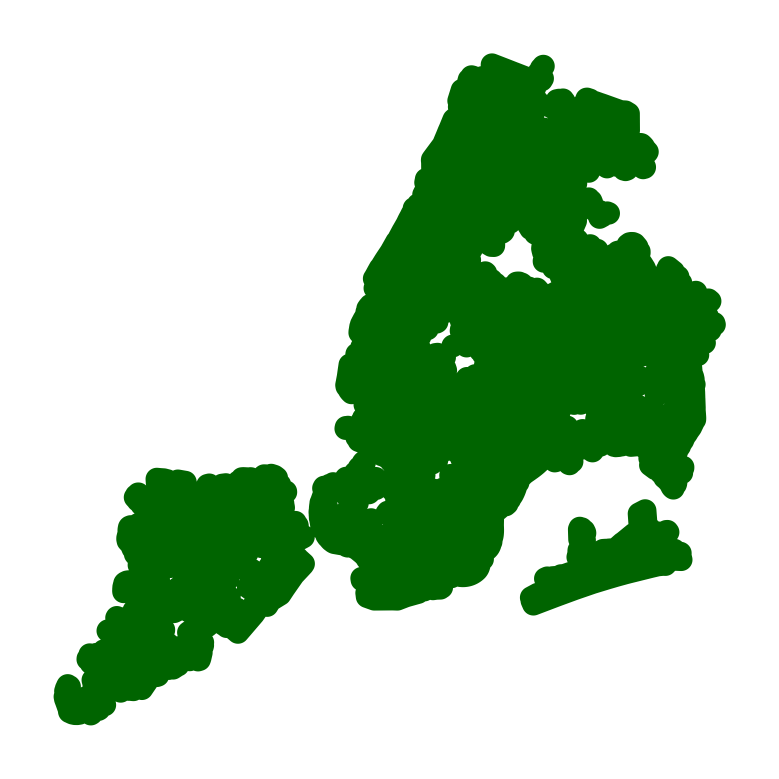

In [13]:
ax = parks_buffer_diss.plot(color='darkgreen')
ax.set_axis_off();

In [14]:
subway_stations_sjoin = subway_stations.sjoin(parks_buffer_diss, how="left")
subway_stations_sjoin.head()

station_id north_direction_label     line daytime_routes complex_id  \
0          1             Last Stop  Astoria            N W          1   
1          2               Astoria  Astoria            N W          2   
2          3               Astoria  Astoria            N W          3   
3          4               Astoria  Astoria            N W          4   
4          5               Astoria  Astoria            N W          5   

  division ada_southbound gtfs_stop_id structure ada_notes  ...   gisobjid  \
0      BMT              0          R01  Elevated      None  ...  100003823   
1      BMT              1          R03  Elevated      None  ...  100003823   
2      BMT              0          R04  Elevated      None  ...  100003823   
3      BMT              0          R05  Elevated      None  ...  100003823   
4      BMT              0          R06  Elevated      None  ...  100003823   

               signname        address permitparent class nys_senate  \
0  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   
1  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   
2  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   
3  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   
4  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   

  permitdistrict borough_right waterfront  10_min_from_park  
0           M-12             M        0.0               1.0  
1           M-12             M        0.0               1.0  
2           M-12             M        0.0               1.0  
3           M-12             M        0.0               1.0  
4           M-12             M        0.0               1.0  

[5 rows x 54 columns]

In [15]:
# almost all subway stations are within 10 minutes of a park!
# missing values of our indicator column indicate that it didn't intersect with the park buffer zone
per_10_min_park = (subway_stations_sjoin['10_min_from_park'].notna().mean()*100)
print(f'{per_10_min_park.round(2)}% of subway stations are within 10 minutes of a park')

99.8% of subway stations are within 10 minutes of a park


In [16]:
# what is the one subway station that is not within 10 minutes from a park?
subway_stations_sjoin[subway_stations_sjoin['10_min_from_park'].isna()]

station_id north_direction_label        line daytime_routes complex_id  \
195        195             Manhattan  Liberty Av              A        195   

    division ada_southbound gtfs_stop_id structure ada_notes  ... gisobjid  \
195      IND              1          A65  Elevated      None  ...      NaN   

    signname address permitparent class nys_senate permitdistrict  \
195      NaN     NaN          NaN   NaN        NaN            NaN   

    borough_right waterfront  10_min_from_park  
195           NaN        NaN               NaN  

[1 rows x 54 columns]

Creating a buffer assumes that straight-line distance is sufficient. But, realistically, straight-line distance is quite a strong assumption.

Now, we'll try calculating the number of subway stations within 10 minutes from a park but we'll calculate distance along a street network.

## Download the street network

We'll download the street network using OSMnx. OSMnx retrieves the place boundaries of the city from the [Nominatim API](https://nominatim.org/), which uses OpenStreetMap data. It retrieves the street networks via the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) (another API using OpenStreetMap) data. Then, it constructs a graphical model where nodes represent intersections and edges represent streets.

OSMnx leverages [NetworkX](https://networkx.org/documentation/stable/) for constructing graphs, which we've seen in previous notebooks.

It also provides functions for converting between graphs and geodataframes.

In [17]:
# setup, we'll load data for NYC
place = 'New York, NY, USA'
network_type = 'walk'
trip_times = [5, 10] # minutes

In [18]:
# download the street network, this may take a few minutes
G = ox.graph_from_place(place, network_type=network_type)

Let's compute some basic stats about the street network. For example, the number of nodes and the average edge length.

In [19]:
# stats = ox.stats.basic_stats(G)
# stats

In [20]:
# project the graph
G = ox.project_graph(G, to_crs=2263)

In [21]:
# store the nodes as a geodataframe
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
gdf_nodes.head()

y              x  street_count   highway  ref railway  \
osmid                                                                           
30807314    227359.977982  994335.758324             4       NaN  NaN     NaN   
2057103273  226874.729134  994265.458967             4       NaN  NaN     NaN   
6579409036  227473.933093  994488.505785             3       NaN  NaN     NaN   
4303265016  227339.914966  994363.844744             3       NaN  NaN     NaN   
1203806304  227403.098947  994297.112369             4  crossing  NaN     NaN   

           junction                       geometry  
osmid                                               
30807314        NaN  POINT (994335.758 227359.978)  
2057103273      NaN  POINT (994265.459 226874.729)  
6579409036      NaN  POINT (994488.506 227473.933)  
4303265016      NaN  POINT (994363.845 227339.915)  
1203806304      NaN  POINT (994297.112 227403.099)

In [22]:
# get the nearest street nodes from the park centroids
park_nodes = ox.nearest_nodes(G, parks_proj.centroid.x, parks_proj.centroid.y)


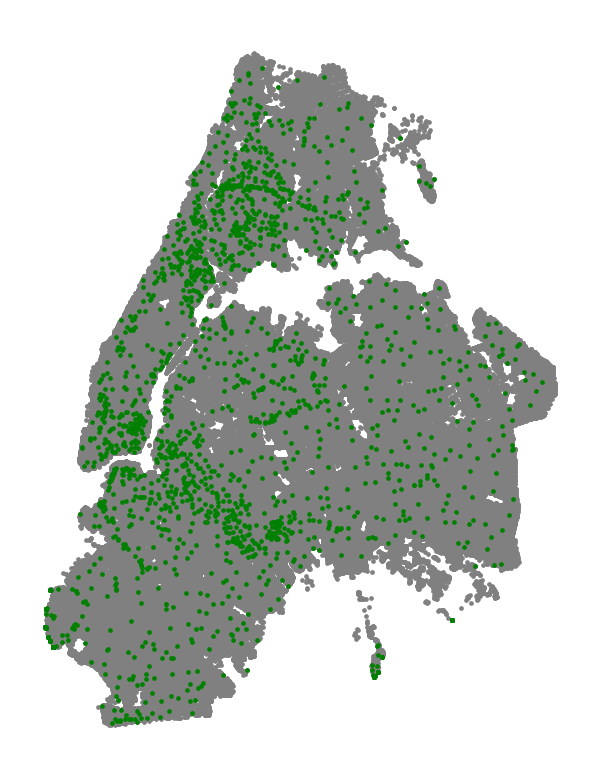

In [23]:
ax = gdf_nodes.plot(color='gray', markersize=0.5)
gdf_nodes.loc[park_nodes].plot(ax=ax, color='green', markersize=0.5)
ax.set_axis_off();

In [24]:
# add an edge attribute for time in minutes required to traverse each edge
for u, v, k, data in G.edges(data=True, keys=True):
    data['length'] = data['length']*3.28084 # osmnx internal units are meters
    data['time'] = data['length'] / (4.6 * 60) # divide by feet per minute

## How far can you walk on foot within each time?

In [31]:
# get one color for each isochrone
#iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0)
iso_colors = ['darkgreen', 'green']
iso_colors

['darkgreen', 'green']

In [32]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for park_node in tqdm(park_nodes):
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G, park_node, radius=trip_time, distance='time')
        for node in subgraph.nodes():
            node_colors[node] = color
node_colors

100%|██████████| 2052/2052 [00:24<00:00, 85.43it/s] 


{9561395217: 'green',
 9561395219: 'green',
 9561395221: 'green',
 9561395222: 'green',
 5071822871: 'green',
 9561395242: 'green',
 9561395246: 'green',
 9561395247: 'green',
 9561395248: 'green',
 9561395252: 'green',
 1205714997: 'green',
 9561395258: 'green',
 9561395259: 'green',
 9561395262: 'green',
 9561395263: 'green',
 9561395264: 'green',
 9561395265: 'green',
 9561395266: 'green',
 9561395268: 'green',
 9561395269: 'green',
 12001052740: 'darkgreen',
 9561395271: 'green',
 12001052746: 'darkgreen',
 9561395275: 'green',
 3805630539: 'green',
 9561395277: 'green',
 9561395278: 'green',
 9561395279: 'green',
 9561395280: 'green',
 9561395281: 'green',
 11596111951: 'darkgreen',
 9561395283: 'green',
 9561395284: 'green',
 9561395285: 'green',
 11596111952: 'darkgreen',
 5608300628: 'darkgreen',
 11596111953: 'darkgreen',
 5608300631: 'darkgreen',
 5608300633: 'darkgreen',
 11596111960: 'darkgreen',
 11596111961: 'darkgreen',
 11596111959: 'darkgreen',
 11596111962: 'darkgreen

Now, we'll plot the street *nodes* that are within 5 and 10 minutes of a park

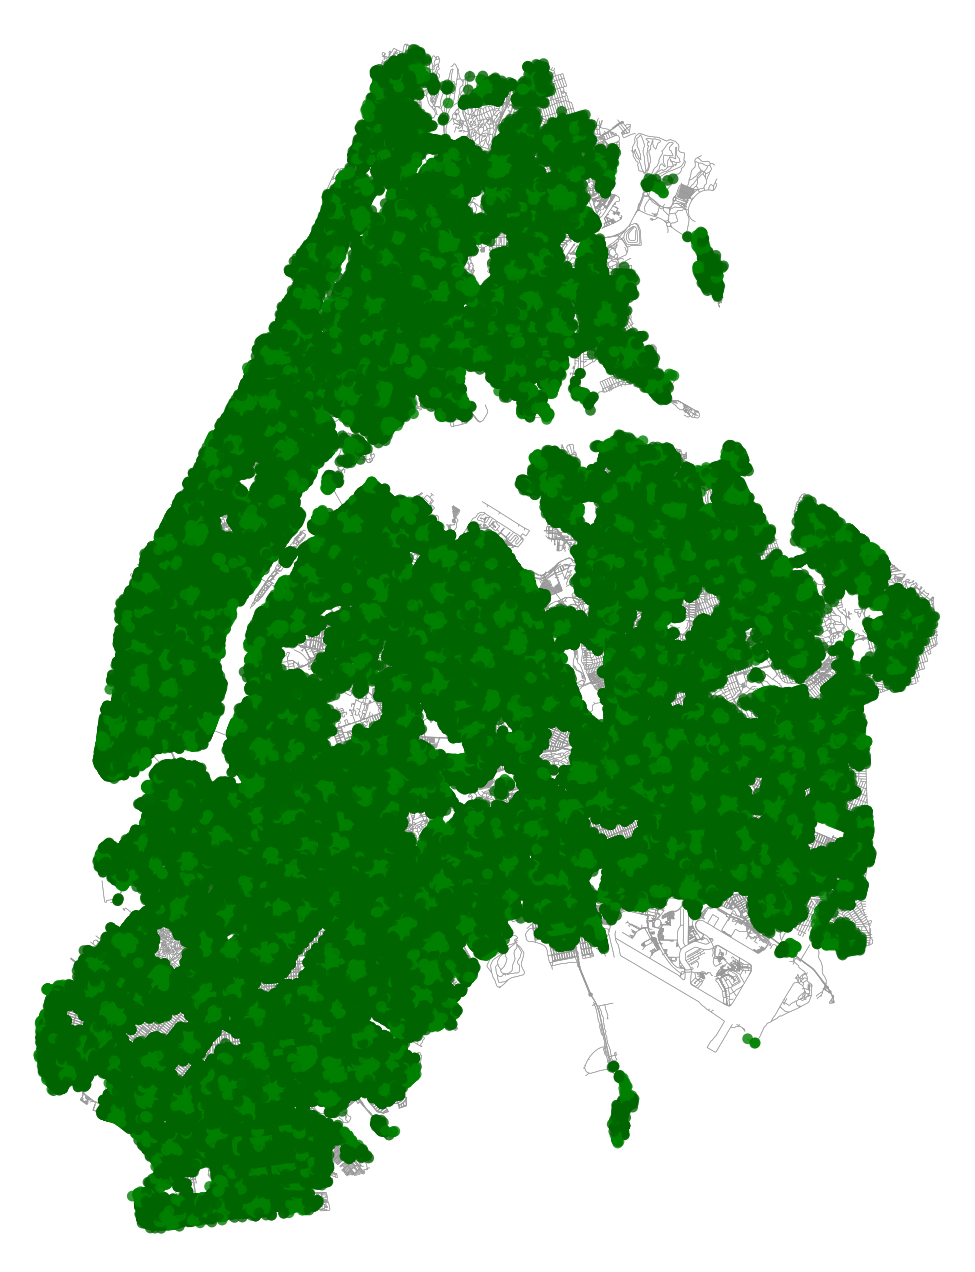

In [33]:
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='w', edge_linewidth=0.2, edge_color='#999999')

## Produce Isochrones

* Approach 1: Using Convex Hull

In [72]:
# make the isochrone polygons, using convex hull
isochrone_polys = {5: [], 10: []}
for park_node in tqdm(park_nodes):
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, park_node, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).union_all().convex_hull
        isochrone_polys[trip_time].append(bounding_poly)
isochrone_polys

100%|██████████| 2052/2052 [00:31<00:00, 65.99it/s] 


{5: [<POLYGON ((1006058.048 254119.559, 1005150.647 254526.342, 1004745.71 254759...>,
  <POLYGON ((1014667.447 247825.562, 1014588.514 248178.287, 1014518.471 24856...>,
  <POLYGON ((1016224.79 246930.062, 1016064.292 246969.199, 1016027.649 246997...>,
  <POLYGON ((1015542.895 204731.814, 1015481.03 204776.474, 1015156.887 205256...>,
  <POLYGON ((998103.866 219019.531, 997352.016 219106.369, 997281.913 219147.3...>,
  <POLYGON ((999360.529 231421.282, 999289.906 231459.931, 998663.536 232406.7...>,
  <POLYGON ((1010947.552 243508.877, 1010785.219 243567.502, 1010639.434 24362...>,
  <POLYGON ((992876.235 230137.639, 992767.597 230195.019, 992394.942 230402.9...>,
  <POLYGON ((990877.049 192542.481, 990848.792 192543.311, 989715.233 193060.0...>,
  <POLYGON ((1035187.777 159947.323, 1034341.381 160291.819, 1035049.48 160977...>,
  <POLYGON ((994117.397 148380.865, 992936.508 148673.402, 992923.267 148721.1...>,
  <POINT (974090.282 161813.292)>,
  <POINT (974090.282 161813.292)>,
  <

In [91]:
# create dataframe of convex hulls
isochrone_gdf_list = []
for trip_time in [5, 10]:
    isochrone_gdf_list += [gpd.GeoDataFrame(geometry=isochrone_polys[trip_time], crs=2263).assign(trip_time=trip_time)]
isochrone_gpd = pd.concat(isochrone_gdf_list)

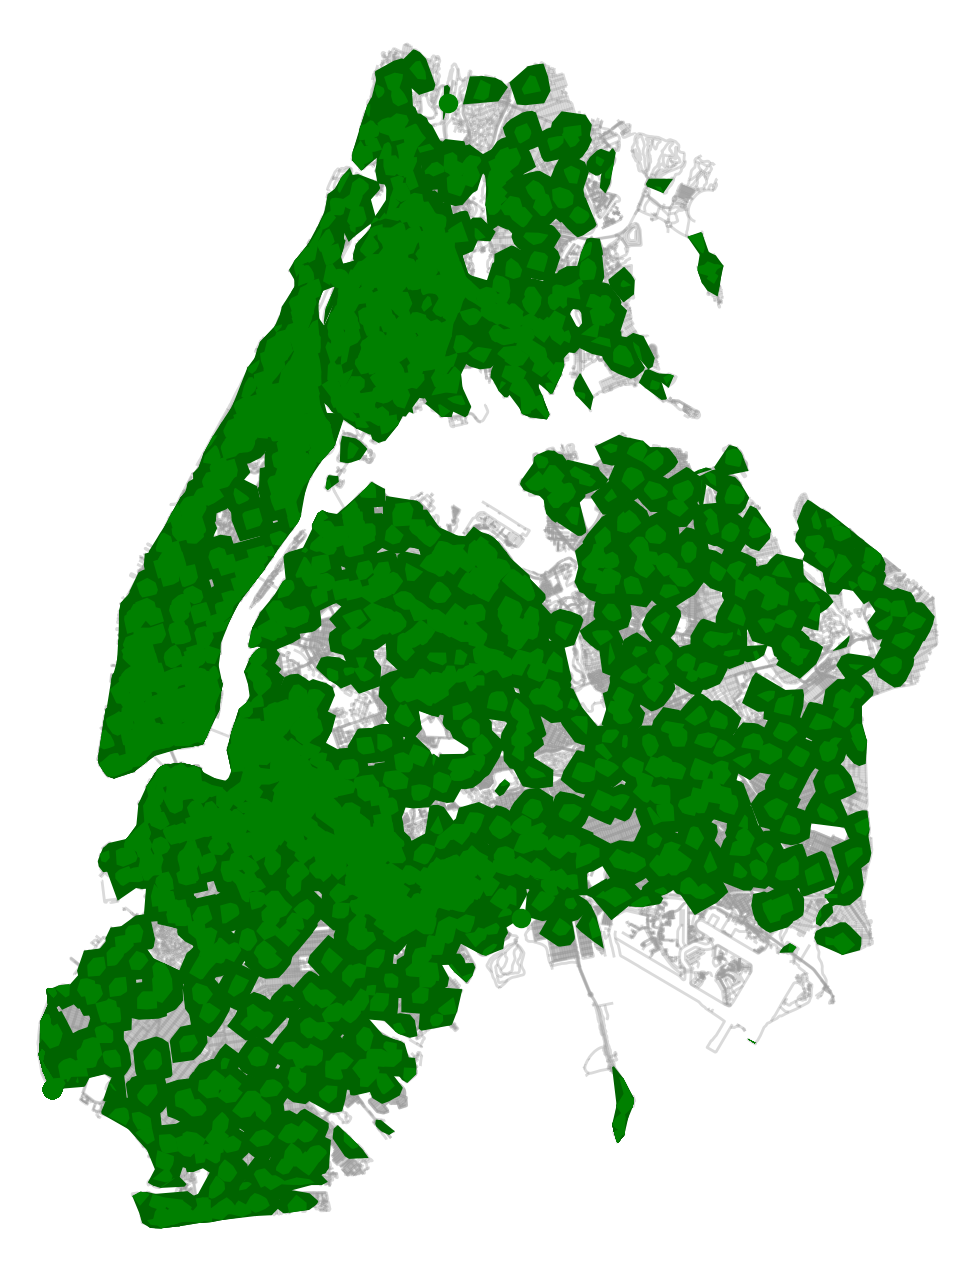

In [92]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='w')
isochrone_gpd[isochrone_gpd['trip_time']==10].plot(ax=ax, color='darkgreen')
isochrone_gpd[isochrone_gpd['trip_time']==5].plot(ax=ax, color='green')
ax.set_axis_off()
plt.show()

In [93]:
isochrone_gpd_diss = isochrone_gpd[isochrone_gpd['trip_time']==10].dissolve()
isochrone_gpd_diss['10_min_from_park'] = 1
subway_stations_iso_sjoin = subway_stations.sjoin(isochrone_gpd_diss, how="left")
subway_stations_iso_sjoin.head()

station_id north_direction_label     line daytime_routes complex_id  \
0          1             Last Stop  Astoria            N W          1   
1          2               Astoria  Astoria            N W          2   
2          3               Astoria  Astoria            N W          3   
3          4               Astoria  Astoria            N W          4   
4          5               Astoria  Astoria            N W          5   

  division ada_southbound gtfs_stop_id structure ada_notes  ...  \
0      BMT              0          R01  Elevated      None  ...   
1      BMT              1          R03  Elevated      None  ...   
2      BMT              0          R04  Elevated      None  ...   
3      BMT              0          R05  Elevated      None  ...   
4      BMT              0          R06  Elevated      None  ...   

  ada_northbound ada south_direction_label    cbd borough gtfs_latitude  \
0              0   0             Manhattan  False       Q     40.775036   
1              1   1             Manhattan  False       Q     40.770258   
2              0   0             Manhattan  False       Q     40.766779   
3              0   0             Manhattan  False       Q      40.76182   
4              0   0             Manhattan  False       Q     40.756804   

                         geometry index_right trip_time  10_min_from_park  
0  POINT (1008613.783 221655.805)         0.0      10.0               1.0  
1  POINT (1007006.503 219913.457)         0.0      10.0               1.0  
2  POINT (1006000.508 218645.019)         0.0      10.0               1.0  
3  POINT (1004885.998 216837.319)         0.0      10.0               1.0  
4  POINT (1003760.811 215008.895)         0.0      10.0               1.0  

[5 rows x 22 columns]

In [94]:
subway_stations_iso_sjoin.shape, subway_stations.shape

((496, 22), (496, 19))

In [99]:
# missing values of our indicator column still indicate that it didn't intersect with the park buffer zone
per_10_min_park = (subway_stations_iso_sjoin['10_min_from_park'].notna().mean()*100)
print(f'{per_10_min_park.round(2)}% of subway stations are within 10 minutes of a park using network distance')

90.12% of subway stations are within 10 minutes of a park using network distance


## Plot isochrones as buffers

In [184]:
def create_edge_lines(G, nodes_gdf, n_fr, n_to):
    f = nodes_gdf.loc[n_fr].geometry
    t = nodes_gdf.loc[n_to].geometry
    return G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))

def make_iso_polys(nd, G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = {5: [], 10: []}
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, nd, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            edge_lookup = create_edge_lines(G, nodes_gdf, n_fr, n_to)
            edge_lines.append(edge_lookup)
            

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).union_all()
        isochrone_polys[trip_time].append(new_iso)
    return isochrone_polys
#res = Parallel(n_jobs=4)(delayed(make_iso_polys)(nd, G) for nd in park_nodes[:10])
res = [make_iso_polys(nd, G, edge_buff=25, node_buff=0, infill=True) for nd in tqdm(park_nodes)]





































































Exception ignored in: <function tqdm.__del__ at 0x35bf58cc0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pubpol2130/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/anaconda3/envs/pubpol2130/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'















































































































































































































































































































































































































































































































In [185]:
isochrone_polys = {5: [], 10: []}
for i in res:
    isochrone_polys[5].append(i[5][0])
    isochrone_polys[10].append(i[10][0])
isochrone_polys

{5: [<POLYGON ((1004749.456 254734.673, 1004748.384 254734.564, 1004747.313 25473...>,
  <POLYGON ((1014688.425 247811.963, 1014686.991 247809.973, 1014685.369 24780...>,
  <POLYGON ((1016057.57 246945.149, 1016056.705 246945.378, 1016056.394 246945...>,
  <POLYGON ((1015269.132 205227.982, 1015268.193 205228.058, 1015267.253 20522...>,
  <POLYGON ((997372.258 219091.697, 997371.57 219090.841, 997370.892 219089.97...>,
  <POLYGON ((998650.368 232385.493, 998649.354 232386.121, 998649.327 232386.1...>,
  <POLYGON ((1011386.639 243725.389, 1011372.454 243682.142, 1011359.24 243640...>,
  <POLYGON ((992390.277 230376.689, 992388.904 230377.446, 992382.202 230381.4...>,
  <POLYGON ((989677.259 193112.899, 989674.808 193112.787, 989672.358 193112.9...>,
  <POLYGON ((1035098.528 160243.945, 1035098.537 160241.492, 1035098.306 16023...>,
  <POLYGON ((993056.07 148637.484, 993055.98 148637.48, 993054.845 148637.546,...>,
  <GEOMETRYCOLLECTION EMPTY>,
  <GEOMETRYCOLLECTION EMPTY>,
  <POLYGON ((

In [186]:
# create dataframe of buffer regions
isochrone_buffer_gdf_list = []
for trip_time in [5, 10]:
    isochrone_buffer_gdf_list += [gpd.GeoDataFrame(geometry=isochrone_polys[trip_time], crs=2263).assign(trip_time=trip_time)]
isochrone_buffer_gpd = pd.concat(isochrone_buffer_gdf_list)

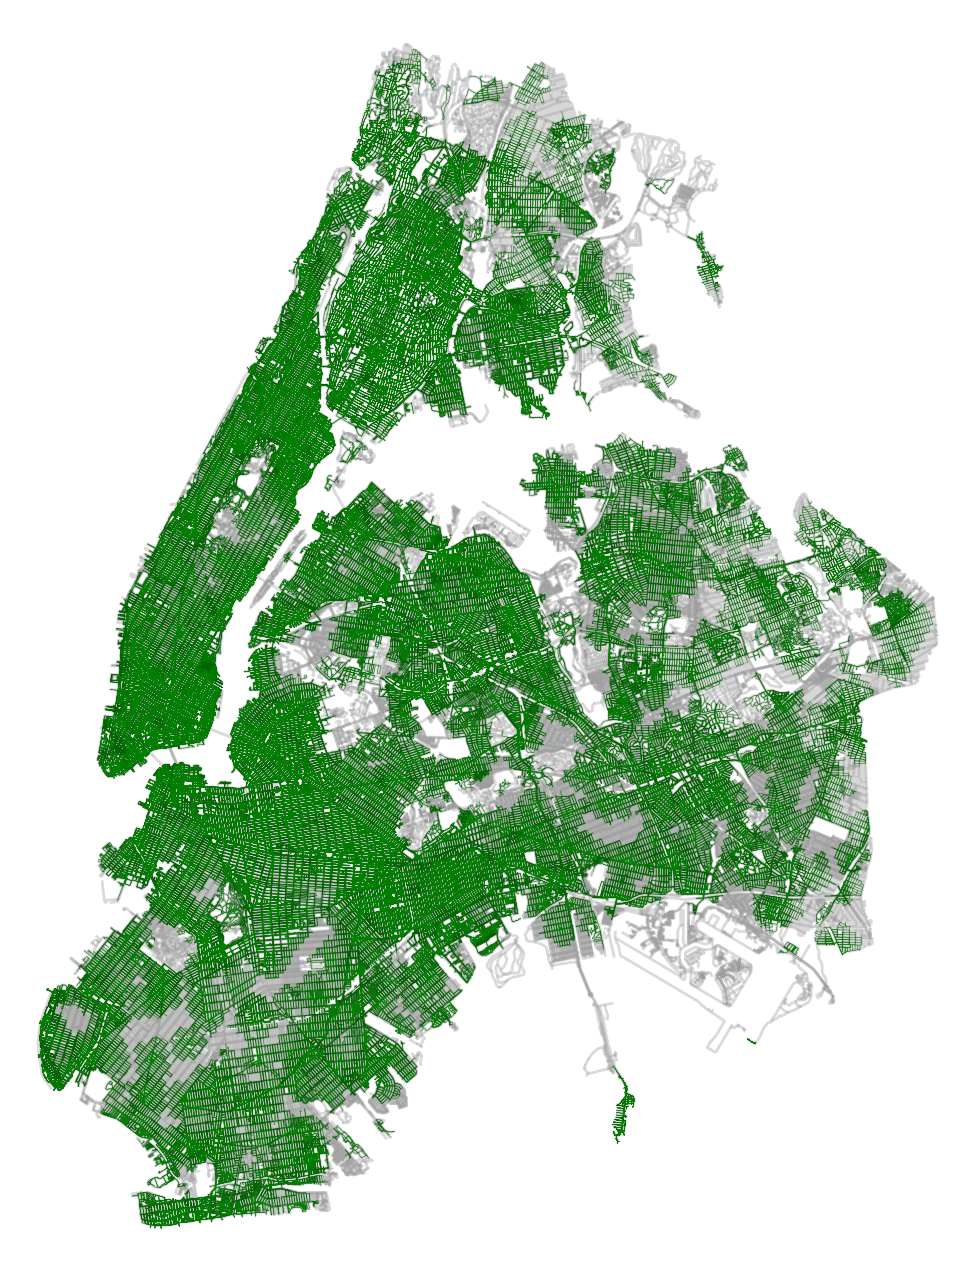

In [187]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='w')
isochrone_buffer_gpd[isochrone_buffer_gpd['trip_time']==10].plot(ax=ax, color='darkgreen')
isochrone_buffer_gpd[isochrone_buffer_gpd['trip_time']==5].plot(ax=ax, color='green')
ax.set_axis_off()
plt.show()